In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2022-08-10 08:42:43.753808: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-08-10 08:42:43.753935: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
print('Running on TPU ', tpu.master())

2022-08-10 08:42:49.842462: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-10 08:42:49.844989: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-08-10 08:42:49.845023: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-10 08:42:49.845052: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (705efacc1913): /proc/driver/nvidia/version does not exist
2022-08-10 08:42:49.848516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU  grpc://10.0.0.2:8470


In [3]:
NUM_WORDS = 5000
EMBEDDING_DIM = 300
MAXLEN = 500
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [4]:
def remove_stop_words(dataframe):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as",
                 "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
                 "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has",
                 "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself",
                 "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself",
                 "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours",
                 "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that",
                 "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", 
                 "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're",
                 "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", 
                 "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    clean_reviews = []
    for i in range(len(dataframe)):
        review = dataframe.review_text.iloc[i]
        review = review.lower()
        clean_review = " ".join([word for word in review.split(" ") if word not in stopwords])
        
        clean_reviews.append(clean_review)
    return clean_reviews

In [5]:
def fit_tokenizer(review_list, num_words, oov_token):
    
    tokenizer = Tokenizer(num_words=num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(review_list)
    return tokenizer

def _get_padded_sequences(tokenizer, reviews, padding, maxlen):
    
    sequences = tokenizer.texts_to_sequences(reviews)
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    return padded_sequences

In [6]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

In [7]:
train_full_data = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv")

# Normalise numerical features:

In [8]:
scaler = StandardScaler()
train_full_data["n_votes_norm"] = scaler.fit_transform(train_full_data.n_votes.to_numpy().reshape(-1, 1))
train_full_data["n_comments_norm"] =scaler.fit_transform(train_full_data.n_comments.to_numpy().reshape(-1, 1))

# Split and process data:

In [9]:
%%time
train_data, val_data = train_test_split(train_full_data, test_size=0.2, random_state=42)
train_labels = train_data.rating
train_sentences = remove_stop_words(train_data)
train_numerical = train_data[["n_votes_norm", "n_comments_norm"]].to_numpy()

val_labels = val_data.rating
val_sentences = remove_stop_words(val_data)
val_numerical = val_data[["n_votes_norm", "n_comments_norm"]].to_numpy()

print(f"There are {len(train_sentences)} reviews for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(train_numerical)} numerical features for training.\n")
print(f"There are {len(val_sentences)} reviews for validation.\n")
print(f"There are {len(val_labels)} labels for validation.\n")
print(f"There are {len(val_numerical)} numerical features for validation.")


There are 720000 reviews for training.

There are 720000 labels for training.

There are 720000 numerical features for training.

There are 180000 reviews for validation.

There are 180000 labels for validation.

There are 180000 numerical features for validation.
CPU times: user 6min 11s, sys: 1.36 s, total: 6min 13s
Wall time: 6min 13s


In [10]:
%%time
tokenizer = fit_tokenizer(train_sentences, num_words=NUM_WORDS, oov_token=OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

train_padded_seq = _get_padded_sequences(tokenizer, train_sentences, PADDING, MAXLEN)
val_padded_seq = _get_padded_sequences(tokenizer, val_sentences, PADDING, MAXLEN)

print(f"Padded training reviews have shape: {train_padded_seq.shape}\n")
print(f"Padded validation reviews have shape: {val_padded_seq.shape}")

Vocabulary contains 317717 words

<OOV> token included in vocabulary
Padded training reviews have shape: (720000, 500)

Padded validation reviews have shape: (180000, 500)
CPU times: user 2min 34s, sys: 1.55 s, total: 2min 35s
Wall time: 2min 35s


In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-08-10 08:52:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-10 08:52:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-10 08:52:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [12]:
%%time
embeddings_index = {}
with open("./glove.6B.300d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 110327 words (207390 misses)
CPU times: user 19.7 s, sys: 885 ms, total: 20.6 s
Wall time: 20.6 s


# Model:

In [16]:
def text_head(num_words, embedding_dim, word_index, embedd_matrix, inputs):
    
    embedding_layer = tf.keras.layers.Embedding(input_dim=len(word_index) + 1,
                                                output_dim=embedding_dim,
                                                weights=[embedd_matrix],
                                                input_length=MAXLEN,
                                                trainable=False)(inputs)
#     conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu")(embedding_layer)
#     max_pool1 = tf.keras.layers.AveragePooling1D(2)(conv1)
#     conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu")(max_pool1)
#     max_pool2 = tf.keras.layers.AveragePooling1D(2)(conv2)
#     conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu")(max_pool2)
#     max_pool3 = tf.keras.layers.AveragePooling1D(2)(conv3)
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(110, return_sequences=True, dropout=0.3))(embedding_layer)
    lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.3))(lstm)
    lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(90, return_sequences=True, dropout=0.3))(lstm2)
    lstm4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(80, return_sequences=True, dropout=0.3))(lstm3)
    global_max = tf.keras.layers.GlobalMaxPooling1D()(lstm4)  
    return global_max

def num_head(inputs):
    
    dense1 = tf.keras.layers.Dense(32, activation="relu")(inputs)
#     dropout = tf.keras.layers.Dropout(0.3)(dense1)
    dense2 = tf.keras.layers.Dense(16, activation="relu")(dense1)
    return dense2

def final_model():
    
    text_input = tf.keras.layers.Input(shape=(MAXLEN,))
    numerical_input = tf.keras.layers.Input(shape=(2,))

    text_feat_extract = text_head(NUM_WORDS, EMBEDDING_DIM, word_index, embedding_matrix, text_input)
    num_feat_extract = num_head(numerical_input)
    concat = tf.keras.layers.concatenate([text_feat_extract, num_feat_extract])
    
    dense1 = tf.keras.layers.Dense(256, activation="relu")(concat)
    dropout = tf.keras.layers.Dropout(0.4)(dense1)
    dense2 = tf.keras.layers.Dense(128, activation="relu")(dense1)
    dropout2 = tf.keras.layers.Dropout(0.4)(dense2)
    outputs = tf.keras.layers.Dense(6, activation="softmax")(dropout2)
    
    model = tf.keras.Model(inputs=[text_input, numerical_input], outputs=[outputs])
    return model
    

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     95315400    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 500, 220)     361680      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 500, 200)     256800      bidirectional_4[0][0]            
____________________________________________________________________________________________

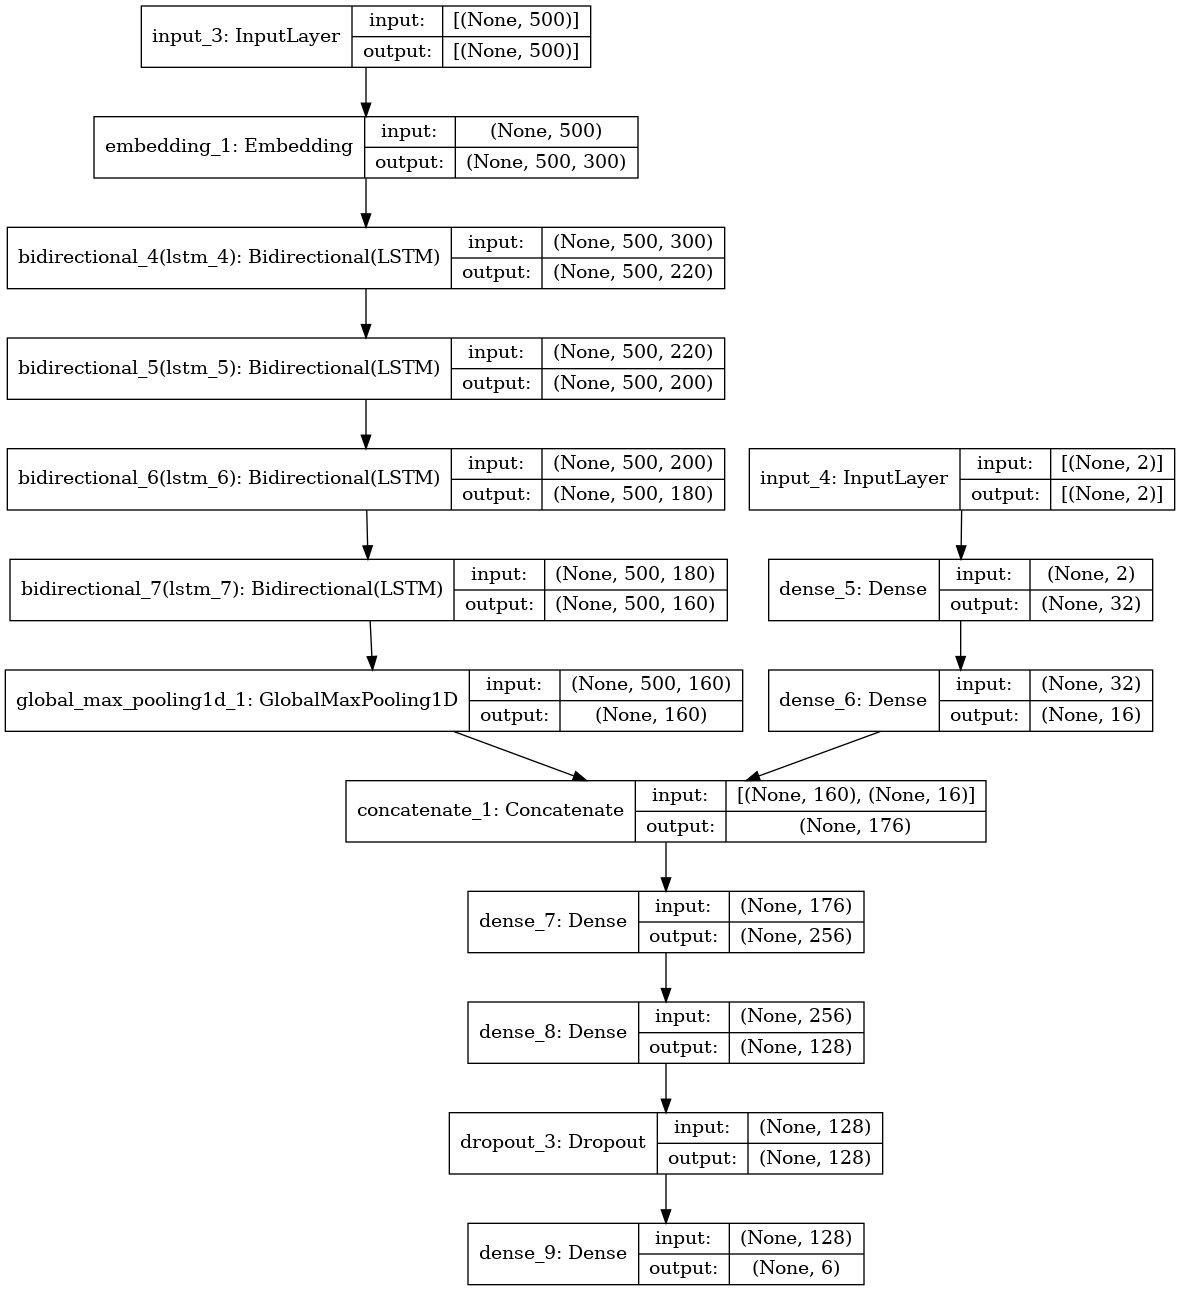

In [17]:
with tpu_strategy.scope():
    model = final_model()
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy']) 
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
history = model.fit(x=[train_padded_seq, train_numerical], 
                    y=train_labels, 
                    epochs=15,
                    batch_size=128,
                    validation_data=([val_padded_seq, val_numerical], val_labels),
                    callbacks=[early_stop]
                   )

2022-08-10 10:13:54.631755: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1440000000 exceeds 10% of free system memory.


Epoch 1/15
5625/5625 [==============================] - 628s 109ms/step - loss: 1.1732 - accuracy: 0.4950 - val_loss: 0.9702 - val_accuracy: 0.5844
Epoch 2/15
5625/5625 [==============================] - 603s 107ms/step - loss: 0.9829 - accuracy: 0.5808 - val_loss: 0.9329 - val_accuracy: 0.6009
Epoch 3/15
5625/5625 [==============================] - 604s 107ms/step - loss: 0.9424 - accuracy: 0.5984 - val_loss: 0.9183 - val_accuracy: 0.6090
Epoch 4/15
5625/5625 [==============================] - 603s 107ms/step - loss: 0.9219 - accuracy: 0.6071 - val_loss: 0.9022 - val_accuracy: 0.6152
Epoch 5/15
5625/5625 [==============================] - 604s 107ms/step - loss: 0.9068 - accuracy: 0.6139 - val_loss: 0.9039 - val_accuracy: 0.6153
Epoch 6/15
5625/5625 [==============================] - 605s 108ms/step - loss: 0.9002 - accuracy: 0.6157 - val_loss: 0.8967 - val_accuracy: 0.6181
Epoch 7/15
5625/5625 [==============================] - 605s 108ms/step - loss: 0.8928 - accuracy: 0.6192 - val_

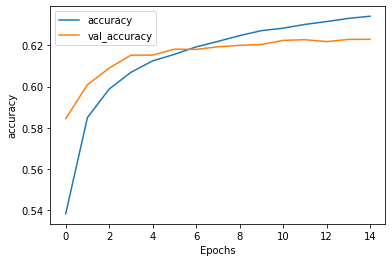

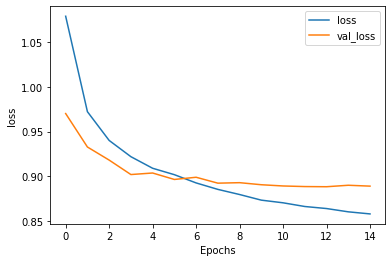

In [19]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Testing:

In [20]:
test_data = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv")

In [21]:
test_data["n_votes_norm"] = scaler.fit_transform(test_data.n_votes.to_numpy().reshape(-1, 1))
test_data["n_comments_norm"] =scaler.fit_transform(test_data.n_comments.to_numpy().reshape(-1, 1))

test_numerical = test_data[["n_votes_norm", "n_comments_norm"]].to_numpy()

In [22]:
%%time
test_reviews = remove_stop_words(test_data)
test_pad_seq = _get_padded_sequences(tokenizer, test_reviews, PADDING, MAXLEN)

CPU times: user 4min 6s, sys: 592 ms, total: 4min 7s
Wall time: 4min 7s


In [23]:
%%time
predictions = model.predict([test_pad_seq, test_numerical])

CPU times: user 26.7 s, sys: 6.81 s, total: 33.5 s
Wall time: 5min 26s


In [24]:
predictions_argmax = np.argmax(predictions, axis=1)

In [25]:
submission_df = pd.DataFrame(zip(list(test_data.review_id), predictions_argmax), columns=["review_id", "rating"])
submission_df

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,5
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,3
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,5
478029,0b7f352e58caf0fd1f961e98ef04e89c,0
478030,9b19eff33ddb14e9e68fca2e90379e46,5
478031,8be463fed78f0da63e964706f710332b,5


In [26]:
submission_df.to_csv("submission.csv", index=False)